# Molecular Gas Main Sequence (MGMS) Plots for NGVS-VERTICO Sample

Remember: everything must be done at VERTICO Nyquist resolution!

FNSKJFNDKSJNFK!!!! I lost hours of work because the Jupyter notebook crashed. What happened to the checkpoints??? kjsdnkfjnsdkljfnskf


In [1]:
MGMS_PATH =  "/arc/home/IsaacCheng/coop_f2021/galaxies/MGMS/"
%cd "$MGMS_PATH"

from multiprocessing import Pool
from itertools import repeat
import re

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import dill
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS

from ltsfit.lts_linefit import lts_linefit

# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
import radial_profile_utils as rpu
# from radial_profile import RadialProfile
# 
GALDIST = 16.5 * u.Mpc  # distance to Virgo cluster centre

/arc/home/IsaacCheng/coop_f2021/galaxies/MGMS


In [2]:
# ----------------------------------------------------------------------------------------
GALAXIES = np.array(
    [
        "IC3392",
        # "NGC4189",  # ignored flag map, but bad results
        "NGC4192",
        "NGC4216",  # has unflagged foreground star
        "NGC4222",
        "NGC4254",
        "NGC4294",
        "NGC4298",
        "NGC4299",
        "NGC4302",
        "NGC4321",
        "NGC4330",
        "NGC4351",
        "NGC4380",
        "NGC4383",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4405",
        "NGC4419",
        "NGC4424",
        "NGC4450",
        "NGC4501",
        "NGC4522",
        "NGC4532",
        "NGC4535",
        "NGC4548",
        "NGC4567",
        "NGC4568",
        "NGC4569",
        "NGC4579",
        "NGC4580",
        # "NGC4606",  # flag map too intrusive
        "NGC4607",
        "NGC4651",
        "NGC4654",
        "NGC4689",
        "NGC4694",
    ]
)
INCLINATIONS = np.array(
    [
        68,
        # 42,  # ignored flag map, but bad results
        83,
        90,  # has unflagged foreground star
        90,
        39,
        74,
        52,
        14,
        90,
        32,
        90,
        48,
        61,
        56,
        83,
        83,
        80,
        46,
        74,
        61,
        51,
        65,
        82,
        64,
        48,
        37,
        49,
        70,
        69,
        40,
        46,
        # 69,  # flag map too intrusive
        90,
        53,
        61,
        38,
        62,
    ]
)  # degrees
POSITION_ANGLES = np.array(
    [
        219,
        # 70,  # ignored flag map, but bad results
        333,
        20,  # has unflagged foreground star
        238,
        243,
        151,
        132,
        128,
        356,
        280,
        238,
        251,
        158,
        17,
        271,
        304,
        270,
        18,
        131,
        274,
        170,
        320,
        35,
        159,
        12,
        318,
        251,
        211,
        203,
        273,
        337,
        # 38,  # flag map too intrusive
        2,
        75,
        300,
        341,
        323,
    ]
)  # degrees
# ----------------------------------------------------------------------------------------
# N.B. "high inclination" means inclination >= 80 degrees
HIGH_I_GALAXIES = np.array(
    [
        "NGC4192",
        "NGC4216",
        "NGC4222",
        "NGC4302",
        "NGC4330",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4522",
        "NGC4607",
    ]
)
HIGH_I_INCLINATIONS = np.array([83, 90, 90, 90, 90, 83, 83, 80, 82, 90,])  # degrees
HIGH_I_POSITION_ANGLES = np.array(
    [333, 20, 238, 356, 238, 271, 304, 270, 35, 2]
)  # degrees
# ----------------------------------------------------------------------------------------
HIGH_I_HEIGHTS_ARCSEC = np.array(
    [80, 60, 25, 55, 38, 65, 43, 45, 40, 70,]
)  # arcsec, for radial profiles
# ----------------------------------------------------------------------------------------
VCC_GALAXIES = np.array(
    [
        1126,  # IC3392
        # 89,  # NGC4189, ignored flag map, but bad results
        92,  # NGC4192
        167,  # NGC4216, has unflagged foreground star
        187,  # NGC4222
        307,  # NGC4254
        465,  # NGC4294
        483,  # NGC4298
        491,  # NGC4299
        497,  # NGC4302
        596,  # NGC4321
        630,  # NGC4330
        692,  # NGC4351
        792,  # NGC4380
        801,  # NGC4383
        836,  # NGC4388
        865,  # NGC4396
        873,  # NGC4402
        874,  # NGC4405
        958,  # NGC4419
        979,  # NGC4424
        1110,  # NGC4450
        1401,  # NGC4501
        1516,  # NGC4522
        1554,  # NGC4532
        1555,  # NGC4535
        1615,  # NGC4548
        1673,  # NGC4567
        1676,  # NGC4568
        1690,  # NGC4569
        1727,  # NGC4579
        1730,  # NGC4580
        # 1859,  # NGC4606, flag map too intrusive
        1868,  # NGC4607
        -100,  # NGC4651 (EVCC number is 1102, cannot use EVCC number)
        1987,  # NGC4654
        2058,  # NGC4689
        2066,  # NGC4694
    ]
)
# ----------------------------------------------------------------------------------------
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
DECR_NAIVE_MEAN_M_DENSITY_IDX = np.array(
    [
        21, 29, 20, 30, 26, 27, 25, 18, 9, 32, 17, 28, 0, 34, 24, 35, 4, 6, 19, 12, 7, 2, 33, 13, 1, 11, 14, 8, 23, 16, 5, 31, 22, 10, 3, 15,
    ]
)  # simply took nanmean of image, all data corrected for inclination
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
DECR_NAIVE_MEDIAN_M_DENSITY_IDX = np.array(
    [
        30, 26, 21, 29, 20, 9, 25, 27, 17, 34, 24, 0, 32, 28, 12, 19, 35, 4, 6, 18, 11, 33, 7, 13, 5, 10, 1, 2, 14, 16, 22, 23, 8, 3, 15, 31,
    ]
)  # simply took nanmedian of image, all data corrected for inclination
# ----------------------------------------------------------------------------------------
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
DECR_MEAN_M_DENSITY_IDX = np.array(
    [
        29, 18, 21, 30, 27, 26, 28, 0, 17, 35, 25, 9, 12, 34, 32, 16, 14, 24, 4, 20, 11, 33, 19, 6, 7, 23, 2, 5, 22, 3, 1, 8, 13, 10, 31, 15,
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel. All data corrected for inclination
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
DECR_MEDIAN_M_DENSITY_IDX = np.array(
    [
        30, 29, 21, 26, 0, 17, 18, 27, 35, 9, 34, 12, 25, 28, 32, 11, 24, 19, 20, 14, 4, 16, 33, 7, 6, 5, 13, 22, 10, 3, 23, 2, 8, 15, 1, 31
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel. All data corrected for inclination
# ----------------------------------------------------------------------------------------

In [3]:
ALPHA_CO = 4.35  # M_sun/pc^2 per (K km/s)
R_21 = 0.8  # dimensionless. CO(2-1)/CO(1-0) ratio
I_THRESHOLD = 80  # degrees


def get_mgms_quantities(
    galaxy, alpha_co=ALPHA_CO, r_21=R_21, inclination=None, i_threshold=I_THRESHOLD
):
    #
    # Load stellar mass density data
    #
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    galaxy_infile = (
        galpath + f"{galaxy}_regBin_extinctionCorr_nyquist_ugiz_Sigma-star_noNorm_i_corr.pkl"
    )
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        M_density = file["stellar_mass_density"]
        M_density_err = file["stellar_mass_density_err"]
        # print(f"{galaxy}'s bin_dimensions:", file["bin_dimensions"])
        file = None  # free memory
    #
    # Load molecular gas data
    #
    if (
        galaxy == "NGC4321"
    ):  # no 9 arcsec data since native is 10 arcsec. Use 15 arcsec data instead
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/nyquistPix/15arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_15as_np_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/nyquistPix/15arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_15as_np_round_mom0_unc.fits"
    else:
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"
    Ico_data, gal_header = fits.getdata(Ico_path, header=True)
    Ico_unc = fits.getdata(Ico_unc_path)  # uncertainty
    gal_wcs = WCS(gal_header)
    #
    # Convert to gas density (M_sun/pc^2)
    #
    gas_density_i_uncorr = alpha_co / r_21 * Ico_data
    gas_density_unc_i_uncorr = alpha_co / r_21 * Ico_unc
    #
    # Correct for inclination
    #
    if inclination is None:
        inclination = INCLINATIONS[galaxy == GALAXIES]
        if inclination.size != 1:
            raise ValueError(
                f"{galaxy}'s inclination should only have 1 element. inclination = {gal_inclination}"
            )
        inclination = inclination[0]
    gas_density = rpu.correct_for_i(
        gas_density_i_uncorr,
        inclination,
        i_threshold=i_threshold,
        i_replacement=i_threshold,
    )
    gas_density_unc = rpu.correct_for_i(
        gas_density_unc_i_uncorr,
        inclination,
        i_threshold=i_threshold,
        i_replacement=i_threshold,
    )
    #
    # Take log10 of quantities
    #
    log_M_density = np.log10(M_density)
    log_M_density_err = M_density_err / (np.log(10) * M_density)
    log_gas_density = np.log10(gas_density)
    log_gas_density_err = gas_density_unc / (np.log(10) * gas_density)
    #
    # Mask to remove bad pixels (required for LTS fitting)
    #
    mgms_isgood = (
        np.isfinite(log_gas_density)
        & np.isfinite(log_gas_density_err)
        & np.isfinite(log_M_density)
        & np.isfinite(log_M_density_err)
    )
    return (
        log_M_density,
        log_M_density_err,
        log_gas_density,
        log_gas_density_err,
        mgms_isgood,
    )


def do_mgms_lts(galaxy, clip=2.6, pivot_func=np.median, plot=True, frac=None, **kwargs):
    (
        log_M_density,
        log_M_density_err,
        log_gas_density,
        log_gas_density_err,
        mgms_isgood,
    ) = get_mgms_quantities(galaxy, **kwargs)
    pivot = pivot_func(log_M_density[mgms_isgood])
    lts_popt = lts_linefit(
        log_M_density[mgms_isgood],
        log_gas_density[mgms_isgood],
        log_M_density_err[mgms_isgood],
        log_gas_density_err[mgms_isgood],
        clip=clip,
        epsy=True,
        corr=True,
        frac=frac,
        pivot=pivot,
        plot=plot,
        text=True,
    )
    lts_int, lts_slope = lts_popt.ab
    lts_int_err, lts_slope_err = lts_popt.ab_err
    lts_rms = lts_popt.rms
    lts_yint = lts_int - lts_slope * pivot
    lts_yint_err = np.sqrt(lts_int_err ** 2 + (lts_slope_err * pivot) ** 2)
    print(
        f"{galaxy}'s LTS line: y = ({lts_slope} +/- {lts_slope_err}) * x + ({lts_yint} +/- {lts_yint_err})"
    )
    return (
        (
            log_M_density,
            log_M_density_err,
            log_gas_density,
            log_gas_density_err,
            mgms_isgood,
        ),
        (
            pivot,
            lts_slope,
            lts_slope_err,
            lts_int,
            lts_int_err,
            lts_rms,
            lts_yint,
            lts_yint_err,
        ),
    )



# Resolved MGMS (rMGMS) for NGC 4380


/tmp/ipykernel_6836/3365738129.py:68: RuntimeWarning: divide by zero encountered in log10
  log_gas_density = np.log10(gas_density)
/tmp/ipykernel_6836/3365738129.py:68: RuntimeWarning: invalid value encountered in log10
  log_gas_density = np.log10(gas_density)


sig_int:     0.0000      7.9729
Computing sig_int
sig_int:     0.0000      7.9729
sig_int:     0.3034     -0.7185
sig_int:     0.2784     -0.6665
sig_int:     0.1392      0.2494
sig_int:     0.1771     -0.2093
sig_int:     0.1598     -0.0397
sig_int:     0.1563      0.0010
sig_int:     0.1564     -0.0000
Computing sig_int error
sig_int:     0.1564      0.0468
sig_int:     0.3034     -0.6717
sig_int:     0.1660     -0.0590
sig_int:     0.1606     -0.0021
sig_int:     0.1604     -0.0001
sig_int:     0.1603      0.0008
Repeat at best fitting solution
sig_int:     0.1564     -0.0000
################# Values and formal errors ################
 intercept:  0.4247 +/- 0.0054
     slope:  0.539 +/- 0.016
   scatter:  0.1564 +/- 0.0041
Observed rms scatter: 0.16
y = a + b*(x - pivot) with pivot = 1.616
Spearman r=0.71 and p=4.3e-155
Pearson r=0.6 and p=1.1e-99
##########################################################
seconds 14.82
NGC4380's LTS line: y = (0.539282720881638 +/- 0.01573426813685

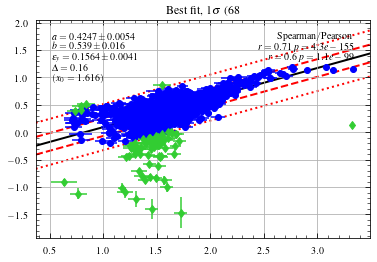

In [4]:
# Set these values
GALAXY_TO_PLOT = "NGC4380"
gal_clip = 2.6
gal_frac = None  # 1 means no outlier rejection
#
gal_inclination = INCLINATIONS[GALAXY_TO_PLOT == GALAXIES]
if gal_inclination.size != 1:
    raise ValueError(
        f"gal_inclination should only have 1 element. gal_inclination = {gal_inclination}"
    )
gal_inclination = gal_inclination[0]
#
(
    (gal_sigstar, gal_sigstar_err, gal_sigmol, gal_sigmol_err, gal_mgms_isgood),
    (
        gal_pivot,
        gal_slope,
        gal_slope_err,
        gal_int,
        gal_int_err,
        gal_rms,
        gal_yint,
        gal_yint_err,
    ),
) = do_mgms_lts(
    GALAXY_TO_PLOT, clip=gal_clip, pivot_func=np.median, inclination=gal_inclination, frac=gal_frac
)

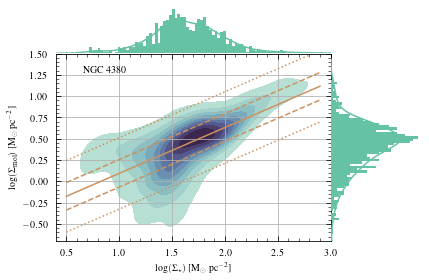

In [5]:
fig, ax, ax_r, ax_t = pu.joint_contour_plot(
    gal_sigstar[gal_mgms_isgood],
    gal_sigmol[gal_mgms_isgood],
    plot_lts=True,
    lts_slope=gal_slope,
    lts_int=gal_int,
    lts_pivot=gal_pivot,
    lts_rms=gal_rms,
    lts_clip=gal_clip,
    # lts_xlim=(-1.8, 0.5),
    # fig_xlim=(-2, 0.75),
    # fig_ylim=(-0.8, 1.6),
    lts_xlim=(0.5, 2.9),  # if using _noNorm
    fig_xlim=(0.4, 3.0),  # if using _noNorm
    fig_ylim=(-0.7, 1.5),  # if using _noNorm
    fig_xlabel=r"$\rm \log(\Sigma_\star)$ [$\rm M_\odot\; pc^{-2}$]",
    fig_ylabel=r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]",
    plot_scatter=False,
    plt_show=False,
    # fig_savename=MGMS_PATH + f"{GALAXY_TO_PLOT}_MGMS_clip{gal_clip}.pdf",
)
#
# Add galaxy name on plot
#
high_i_str = "*" if gal_inclination >= I_THRESHOLD else ""
ax.text(
    0.1,
    0.9,
    re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
    c="k",
    ha="left",
    transform=ax.transAxes,
)
# fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_MGMS_clip{gal_clip}_noNorm_i_corr.pdf")
plt.show()

## Version for beamer slides


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


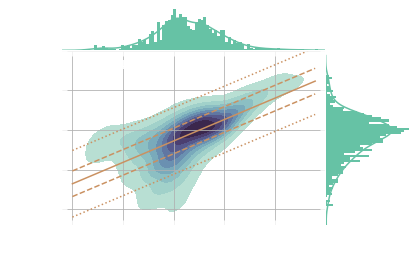

In [11]:
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    fig, ax, ax_r, ax_t = pu.joint_contour_plot(
        gal_sigstar[gal_mgms_isgood],
        gal_sigmol[gal_mgms_isgood],
        plot_lts=True,
        lts_slope=gal_slope,
        lts_int=gal_int,
        lts_pivot=gal_pivot,
        lts_rms=gal_rms,
        lts_clip=gal_clip,
        # lts_xlim=(-1.8, 0.5),
        # fig_xlim=(-2, 0.75),
        # fig_ylim=(-0.8, 1.6),
        lts_xlim=(0.5, 2.9),  # if using _noNorm
        fig_xlim=(0.4, 3.0),  # if using _noNorm
        fig_ylim=(-0.7, 1.5),  # if using _noNorm
        fig_xlabel=r"$\rm \log(\Sigma_\star)$ [$\rm M_\odot\; pc^{-2}$]",
        fig_ylabel=r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]",
        plot_scatter=False,
        plt_show=False,
        # fig_savename=MGMS_PATH + f"{GALAXY_TO_PLOT}_MGMS_clip{gal_clip}_beamer.pdf",
    )
    #
    # Add galaxy name on plot
    #
    high_i_str = "*" if gal_inclination >= I_THRESHOLD else ""
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="w",
        ha="left",
        transform=ax.transAxes,
    )
    # fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_MGMS_clip{gal_clip}_noNorm_i_corr_beamer.pdf")
    plt.show()

## Determine the spatial regions above/below the MGMS


/tmp/ipykernel_6836/1065362250.py:3: RuntimeWarning: divide by zero encountered in log10
  gas_fraction = np.log10((10 ** gal_sigmol) / (10 ** gal_sigstar))


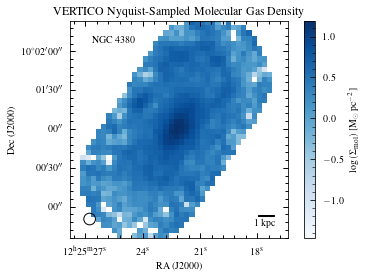

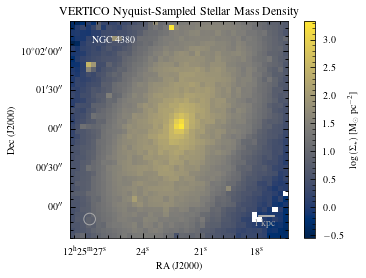

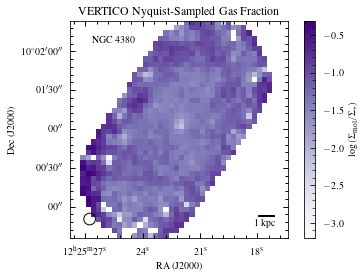

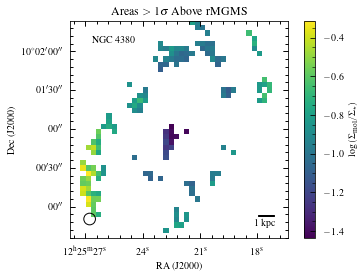

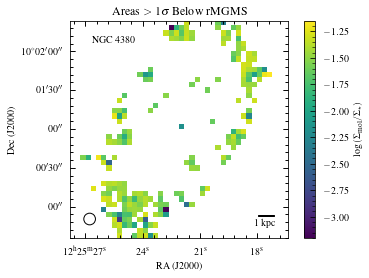

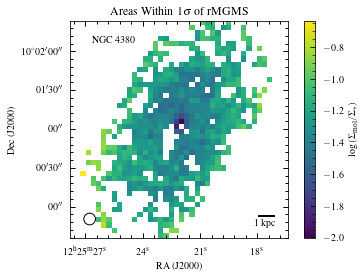

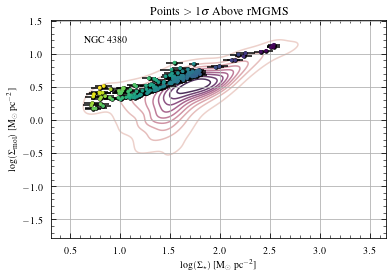

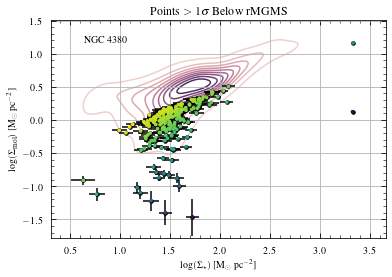

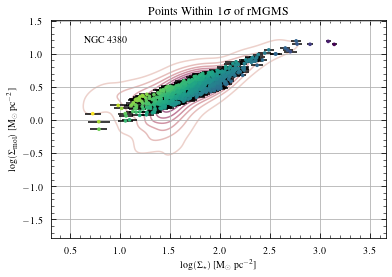

In [6]:
is_above_mgms = gal_sigmol > (gal_int + gal_slope * (gal_sigstar - gal_pivot) + gal_rms)  # above 1 sigma
is_below_mgms = gal_sigmol < (gal_int + gal_slope * (gal_sigstar - gal_pivot) - gal_rms)  # below 1 sigma
gas_fraction = np.log10((10 ** gal_sigmol) / (10 ** gal_sigstar))
gas_fraction_above_mgms = np.copy(gas_fraction)
gas_fraction_above_mgms[(~is_above_mgms) | (~gal_mgms_isgood)] = np.nan
gas_fraction_below_mgms = np.copy(gas_fraction)
gas_fraction_below_mgms[(~is_below_mgms) | (~gal_mgms_isgood)] = np.nan
gas_fraction_on_mgms = np.copy(gas_fraction)
gas_fraction_on_mgms[(is_above_mgms) | (is_below_mgms) | (~gal_mgms_isgood)] = np.nan
# 
# Plots
#
size_vertical = 0.25  # vertical thickness of scale bar
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # ignore astropy warnings
    gal_co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
    co_header = fits.getheader(gal_co_path)
    co_wcs = WCS(co_header)
    high_i_str = "*" if gal_inclination >= I_THRESHOLD else ""
    # Gas density at Nyquist resolution
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gal_sigmol, cmap="Blues", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{mol}\right)$ [$\rm M_\odot\; pc^{-2}$]")
    pu.add_scalebar(ax, co_wcs, GALDIST, size_vertical=size_vertical)
    pu.add_scalebeam(ax, co_header)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"VERTICO Nyquist-Sampled Molecular Gas Density")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_nyquist_gas_density.pdf")
    plt.show()
    # Stellar mass density at Nyquist resolution
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gal_sigstar, cmap="cividis", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{\star}\right)$ [$\rm M_\odot\; pc^{-2}$]")
    pu.add_scalebar(ax, co_wcs, GALDIST, color="darkgrey", size_vertical=size_vertical)
    pu.add_scalebeam(ax, co_header, ec="darkgrey")
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"VERTICO Nyquist-Sampled Stellar Mass Density")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="w",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_nyquist_M_density.pdf")
    plt.show()
    # Gas fraction at Nyquist resolution
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gas_fraction, cmap="Purples", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
    pu.add_scalebar(ax, co_wcs, GALDIST, size_vertical=size_vertical)
    pu.add_scalebeam(ax, co_header)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"VERTICO Nyquist-Sampled Gas Fraction")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_nyquist_gas_fraction.pdf")
    plt.show()
    # Regions > 1 sigma above MGMS (map)
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gas_fraction_above_mgms, cmap="viridis", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
    pu.add_scalebar(ax, co_wcs, GALDIST, size_vertical=size_vertical)
    pu.add_scalebeam(ax, co_header)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"Areas $> 1 \sigma$ Above rMGMS")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_regions_aboveMGMS.pdf")
    plt.show()
    # Regions > 1 sigma below MGMS (map)
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gas_fraction_below_mgms, cmap="viridis", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
    pu.add_scalebar(ax, co_wcs, GALDIST, size_vertical=size_vertical)
    pu.add_scalebeam(ax, co_header)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"Areas $> 1 \sigma$ Below rMGMS")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_regions_belowMGMS.pdf")
    plt.show()
    # Regions within 1 sigma of MGMS (map)
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gas_fraction_on_mgms, cmap="viridis", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
    pu.add_scalebar(ax, co_wcs, GALDIST, size_vertical=size_vertical)
    pu.add_scalebeam(ax, co_header)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"Areas Within $1 \sigma$ of rMGMS")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_regions_onMGMS.pdf")
    plt.show()
    # Points > 1 sigma above MGMS (scatter plot)
    fig, ax = plt.subplots()
    sns.kdeplot(
        ax=ax,
        x=gal_sigstar[gal_mgms_isgood],
        y=gal_sigmol[gal_mgms_isgood],
        cmap=sns.cubehelix_palette(as_cmap=True),
        fill=False,
        zorder=1,
    )
    ax.errorbar(
        x=gal_sigstar[(is_above_mgms) & (gal_mgms_isgood)],
        y=gal_sigmol[(is_above_mgms) & (gal_mgms_isgood)],
        xerr=gal_sigstar_err[(is_above_mgms) & (gal_mgms_isgood)],
        yerr=gal_sigmol_err[(is_above_mgms) & (gal_mgms_isgood)],
        fmt=".",
        color="k",
        markersize=7,
        zorder=2
    )
    ax.scatter(
        gal_sigstar[(is_above_mgms) & (gal_mgms_isgood)],
        gal_sigmol[(is_above_mgms) & (gal_mgms_isgood)],
        c=gas_fraction[(is_above_mgms) & (gal_mgms_isgood)],
        zorder=3,
        s=7,
    )
    ax.set_xlabel(r"$\rm \log(\Sigma_{\star})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_ylabel(r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_title(r"Points $> 1 \sigma$ Above rMGMS")
    # ax.set_xlim(1.0, 4.0)
    # ax.set_ylim(-1.0, 1.5)
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_points_aboveMGMS.pdf")
    plt.show()
    # Points > 1 sigma below MGMS (scatter plot)
    fig, ax = plt.subplots()
    sns.kdeplot(
        ax=ax,
        x=gal_sigstar[gal_mgms_isgood],
        y=gal_sigmol[gal_mgms_isgood],
        cmap=sns.cubehelix_palette(as_cmap=True),
        fill=False,
        zorder=1,
    )
    ax.errorbar(
        x=gal_sigstar[(is_below_mgms) & (gal_mgms_isgood)],
        y=gal_sigmol[(is_below_mgms) & (gal_mgms_isgood)],
        xerr=gal_sigstar_err[(is_below_mgms) & (gal_mgms_isgood)],
        yerr=gal_sigmol_err[(is_below_mgms) & (gal_mgms_isgood)],
        fmt=".",
        color="k",
        markersize=7,
        zorder=2,
    )
    ax.scatter(
        gal_sigstar[(is_below_mgms) & (gal_mgms_isgood)],
        gal_sigmol[(is_below_mgms) & (gal_mgms_isgood)],
        c=gas_fraction[(is_below_mgms) & (gal_mgms_isgood)],
        zorder=3,
        s=7,
    )
    ax.set_xlabel(r"$\rm \log(\Sigma_{\star})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_ylabel(r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_title(r"Points $> 1 \sigma$ Below rMGMS")
    # ax.set_xlim(1.0, 4.0)
    # ax.set_ylim(-1.0, 1.5)
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_points_belowMGMS.pdf")
    plt.show()
    # Points within 1 sigma of MGMS (scatter plot)
    fig, ax = plt.subplots()
    sns.kdeplot(
        ax=ax,
        x=gal_sigstar[gal_mgms_isgood],
        y=gal_sigmol[gal_mgms_isgood],
        cmap=sns.cubehelix_palette(as_cmap=True),
        fill=False,
        zorder=1,
    )
    ax.errorbar(
        x=gal_sigstar[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        y=gal_sigmol[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        xerr=gal_sigstar_err[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        yerr=gal_sigmol_err[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        fmt="None",
        color="k",
        markersize=7,
        zorder=2,
    )
    ax.scatter(
        gal_sigstar[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        gal_sigmol[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        c=gas_fraction[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        zorder=3,
        s=7,
    )
    ax.set_xlabel(r"$\rm \log(\Sigma_{\star})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_ylabel(r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_title(r"Points Within $1 \sigma$ of rMGMS")
    # ax.set_xlim(1.0, 4.0)
    # ax.set_ylim(-1.0, 1.5)
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_points_onMGMS.pdf")
    plt.show()

# Contour plot of just NGC 4302 (since it fails LTS fitting)


/tmp/ipykernel_1723/3365738129.py:68: RuntimeWarning: divide by zero encountered in log10
  log_gas_density = np.log10(gas_density)


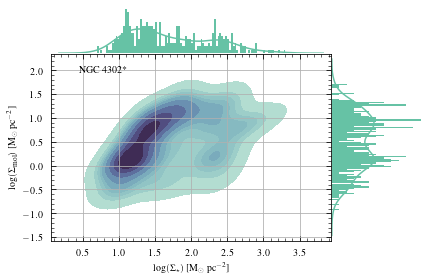

In [4]:
# Set this values
GALAXY_TO_PLOT = "NGC4302"
#
gal_inclination = INCLINATIONS[GALAXY_TO_PLOT == GALAXIES]
if gal_inclination.size != 1:
    raise ValueError(
        f"gal_inclination should only have 1 element. gal_inclination = {gal_inclination}"
    )
gal_inclination = gal_inclination[0]
#
(gal_sigstar, gal_sigstar_err, gal_sigmol, gal_sigmol_err, gal_mgms_isgood) = get_mgms_quantities(
    GALAXY_TO_PLOT, inclination=gal_inclination
)
#
# Plot
#
fig, ax, ax_r, ax_t = pu.joint_contour_plot(
    gal_sigstar[gal_mgms_isgood],
    gal_sigmol[gal_mgms_isgood],
    plot_lts=False,
    fig_xlabel=r"$\rm \log(\Sigma_\star)$ [$\rm M_\odot\; pc^{-2}$]",
    fig_ylabel=r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]",
    plot_scatter=False,
    plt_show=False,
)
#
# Add galaxy name on plot
#
high_i_str = "*" if gal_inclination >= I_THRESHOLD else ""
ax.text(
    0.1,
    0.9,
    re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
    c="k",
    ha="left",
    transform=ax.transAxes,
)
# fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_MGMS_LTSfail_i_corr.pdf")
plt.show()

# rMGMS for all NGVS-VERTICO galaxies

Except NGC 4302 since LTS fitting fails


In [4]:
# Set these parameters
GAL_CLIP = 2.6
LTS_PIVOT_FUNC = np.median
#
if LTS_PIVOT_FUNC == np.median:
    lts_pivot_func_str = "median"
elif LTS_PIVOT_FUNC == np.mean:
    lts_pivot_func_str = "mean"
else:
    raise ValueError(
        "LTS_PIVOT_FUNC must be np.median or np.mean (NaNs are already excluded)"
    )
#
# for gal in GALAXIES:
#     (gal_sigstar, gal_sigstar_err, gal_sigmol, gal_sigmol_err, gal_mgms_isgood), (gal_pivot, gal_slope, gal_slope_err, gal_int, gal_int_err, gal_rms, gal_yint, gal_yint_err) = do_mgms_lts(GALAXY_TO_PLOT, clip=GAL_CLIP, pivot_func=LTS_PIVOT_FUNC, plot=False)
#     with open(MGMS_PATH + f"{gal}_MGMS_clip{GAL_CLIP}.pkl", "wb") as f:
#         dill.dump(
#             {
#                 "log_M_density": gal_sigstar,
#                 "log_M_density_err": gal_sigstar_err,
#                 "log_gas_density": gal_sigmol,
#                 "log_gas_density_err": gal_sigmol_err,
#                 "mgms_isgood": gal_mgms_isgood,
#                 "lts_pivot": gal_pivot,
#                 "lts_pivot_func": lts_pivot_func_str,
#                 "lts_clip": GAL_CLIP,
#                 "lts_slope": gal_slope,
#                 "lts_slope_err": gal_slope_err,
#                 "lts_int": gal_int,
#                 "lts_int_err": gal_int_err,
#                 "lts_rms": gal_rms,
#                 "lts_yint": gal_yint,
#                 "lts_yint_err": gal_yint_err,
#             },
#             f
#         )
def do_mgms_lts_all(gal):
    (
        (gal_sigstar, gal_sigstar_err, gal_sigmol, gal_sigmol_err, gal_mgms_isgood),
        (
            gal_pivot,
            gal_slope,
            gal_slope_err,
            gal_int,
            gal_int_err,
            gal_rms,
            gal_yint,
            gal_yint_err,
        ),
    ) = do_mgms_lts(gal, clip=GAL_CLIP, pivot_func=LTS_PIVOT_FUNC, plot=False)
    with open(MGMS_PATH + f"{gal}_MGMS_clip{GAL_CLIP}_noNorm.pkl", "wb") as f:
        dill.dump(
            {
                "log_M_density": gal_sigstar,
                "log_M_density_err": gal_sigstar_err,
                "log_gas_density": gal_sigmol,
                "log_gas_density_err": gal_sigmol_err,
                "mgms_isgood": gal_mgms_isgood,
                "lts_pivot": gal_pivot,
                "lts_pivot_func": lts_pivot_func_str,
                "lts_clip": GAL_CLIP,
                "lts_slope": gal_slope,
                "lts_slope_err": gal_slope_err,
                "lts_int": gal_int,
                "lts_int_err": gal_int_err,
                "lts_rms": gal_rms,
                "lts_yint": gal_yint,
                "lts_yint_err": gal_yint_err,
            },
            f,
        )
    print("Pickled", MGMS_PATH + f"{gal}_MGMS_clip{GAL_CLIP}_noNorm.pkl")


In [5]:
# NGC4302 will fail
with Pool(processes=None) as p:
    p.map(do_mgms_lts_all, GALAXIES)
print("Done")



WARNINGWARNING

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNINGWARNINGWARNINGWARNING
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [a

sig_int:     0.0000      3.0787
Computing sig_int
sig_int:     0.0000      2.2382
Computing sig_int
sig_int:     0.0000     10.6446
Computing sig_int
sig_int:     0.0000      4.7421
Computing sig_intsig_int:     0.0000      1.1685

Computing sig_intsig_int:     0.0000     37.6536

sig_int:     0.0000     14.0616
sig_int:     0.0000      0.4794Computing sig_intsig_int:     0.0000      0.6397
Computing sig_int
Computing sig_int

Computing sig_int

sig_int:     0.0000      0.8432sig_int:     0.0000      0.2543
Computing sig_int

sig_int:     0.0000     33.5830
Computing sig_intComputing sig_int

sig_int:     0.0000     25.2987
Computing sig_int
sig_int:     0.0000      1.4354
sig_int:     0.0000     17.2956Computing sig_int
Computing sig_int

sig_int:     0.0000      4.4944sig_int:     0.0000      9.2064sig_int:     0.0000      0.5073sig_int:     0.0000      3.4350

Computing sig_intsig_int:     0.0000     36.2413

Computing sig_intComputing sig_int



Computing sig_intComputing sig_intsi

/tmp/ipykernel_54296/3365738129.py:68: RuntimeWarning: invalid value encountered in log10
  log_gas_density = np.log10(gas_density)


sig_int:     0.3950     -0.5695sig_int:     0.1589      0.0934

sig_int:     0.3674     -0.5028
sig_int:     0.3958     -0.5547
sig_int:     0.4792     -0.3515
sig_int:     0.5196     -0.6969
sig_int:     0.3156     -0.3284sig_int:     0.3034     -0.7185
sig_int:     0.2098     -0.2963
sig_int:     0.4204     -0.4155

sig_int:     0.2882     -0.3094
sig_int:     0.4349     -0.4789
sig_int:     0.3574     -0.0015sig_int:     0.4580     -0.7217

sig_int:     0.5110     -0.6138
sig_int:     0.2189      1.0372
sig_int:     0.2467     -0.1244sig_int:     0.5618     -0.0836

sig_int:     0.1694      0.0533sig_int:     0.1529      0.0122

sig_int:     0.1975      0.4114
sig_int:     0.1785     -0.0419
sig_int:     0.3343      0.4913
sig_int:     0.2627     -0.2530
sig_int:     0.2701     -0.1467
sig_int:     0.8616     -0.7679sig_int:     0.2003     -0.0631
sig_int:     0.3739     -0.0138

sig_int:     0.0000      3.3789
sig_int:     0.5684     -0.7337
sig_int:     0.2518     -0.5479
sig_int:

sig_int:     0.3855      0.0006sig_int:     0.3919     -0.0010
sig_int:     0.4101     -0.4689
Computing sig_int error
sig_int:     0.2435     -0.2622

sig_int:     0.1563      0.0010sig_int:     0.1346      0.0006sig_int:     0.3173      0.0008


Computing sig_int error
Computing sig_int error
sig_int:     0.2216     -0.0516
sig_int:     0.2883      0.0458
sig_int:     0.2467      0.0000
sig_int:     0.4380     -0.0031sig_int:     0.1316      0.0523

sig_int:     0.1666     -0.0064
sig_int:     0.2338     -0.0262
sig_int:     0.2492     -0.0648
sig_int:     0.5294     -0.6582
sig_int:     0.2411      0.0474
sig_int:     0.2698     -0.0614sig_int:     0.5466     -0.4901
sig_int:     0.5714     -0.0304

sig_int:     0.1810      0.0004
sig_int:     0.3916      0.0000Computing sig_int error

Repeat at best fitting solution
sig_int:     0.4538     -0.5396sig_int:     0.2468     -0.0006sig_int:     0.1961     -0.0027sig_int:     0.5321     -0.5547



sig_int:     0.1653     -0.0223
Repeat a


sig_int:     0.3491     -0.0584
##########################################################sig_int:     0.2834     -0.0760sig_int:     0.3552     -0.0046

sig_int:     0.1956     -0.0000
seconds 77.90

NGC4299's LTS line: y = (0.4388966180143478 +/- 0.07449872973323132) * x + (-0.3252904572462028 +/- 0.11801740273991769)
sig_int:     0.1660     -0.0003sig_int:     0.2902     -0.0024

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/MGMS/NGC4299_MGMS_clip2.6_noNorm.pkl
sig_int:     0.2354     -0.3553
sig_int:     0.3261     -0.0011
sig_int:     0.4477     -0.4045


sig_int:     0.2560     -0.0006
Repeat at best fitting solutionsig_int:     0.1622     -0.0008

sig_int:     0.1396     -0.0005
sig_int:     0.0000      1.3797
Computing sig_int
sig_int:     0.2558     -0.0143
sig_int:     0.8882     -0.7241sig_int:     0.2609      0.1081

sig_int:     0.2532      0.0381sig_int:     0.1811      0.0709

sig_int:     0.2069     -0.0014
sig_int:     0.3541      0.0000sig_int:     0.2306     -0.0043

sig_int:     0.2106      0.0000
sig_int:     0.9825     -0.7858
sig_int:     0.2563     -0.0658
sig_int:     0.4146     -0.0001
sig_int:     0.1429     -0.0124################# Values and formal errors ################
sig_int:     0.2899     -0.0001

 intercept:  -0.387 +/- 0.028
sig_int:     0.1955      0.0006     slope:  0.741 +/- 0.046

Repeat at best fitting solution
sig_int:     0.2287      0.0000
   scatter:  0.415 +/- 0.023sig_int:     0.5615      0.0000
################# Values and formal errors ################

 intercept:  0.684 +/- 0.029
     slop

ValueError: f(a) and f(b) must have different signs

## Auto-generate rMGMS plots


In [6]:
GAL_CLIP = 2.6
I_THRESHOLD = 80

for gal, gal_i in zip(GALAXIES, INCLINATIONS):
    if gal == "NGC4302":
        continue  # failed LTS fitting. No pickle file
    print("Plotting", gal)
    with open(MGMS_PATH + f"{gal}_MGMS_clip{GAL_CLIP}_noNorm.pkl", "rb") as f:
        file = dill.load(f)
        gal_sigstar = file["log_M_density"]
        gal_sigstar_err = file["log_M_density_err"]
        gal_sigmol = file["log_gas_density"]
        gal_sigmol_err = file["log_gas_density_err"]
        gal_mgms_isgood = file["mgms_isgood"]
        gal_slope = file["lts_slope"]
        gal_int = file["lts_int"]
        gal_pivot = file["lts_pivot"]
        gal_rms = file["lts_rms"]
        gal_clip = file["lts_clip"]
        file = None  # free memory
    fig, ax, ax_r, ax_t = pu.joint_contour_plot(
        gal_sigstar[gal_mgms_isgood],
        gal_sigmol[gal_mgms_isgood],
        plot_lts=True,
        lts_slope=gal_slope,
        lts_int=gal_int,
        lts_pivot=gal_pivot,
        lts_rms=gal_rms,
        lts_clip=gal_clip,
        fig_xlabel=r"$\rm \log(\Sigma_\star)$ [$\rm M_\odot\; pc^{-2}$]",
        fig_ylabel=r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]",
        plot_scatter=False,
        plt_show=False,
    )
    #
    # Add galaxy name on plot
    #
    high_i_str = "*" if gal_i >= I_THRESHOLD else ""
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", gal) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{gal}_MGMS_clip{gal_clip}_autoGenerated_noNorm_i_corr.pdf")
    plt.close()

Plotting IC3392
Plotting NGC4192
Plotting NGC4216
Plotting NGC4222
Plotting NGC4254
Plotting NGC4294
Plotting NGC4298
Plotting NGC4299
Plotting NGC4321
Plotting NGC4330
Plotting NGC4351
Plotting NGC4380
Plotting NGC4383
Plotting NGC4388
Plotting NGC4396
Plotting NGC4402
Plotting NGC4405
Plotting NGC4419
Plotting NGC4424
Plotting NGC4450
Plotting NGC4501
Plotting NGC4522
Plotting NGC4532
Plotting NGC4535
Plotting NGC4548
Plotting NGC4567
Plotting NGC4568
Plotting NGC4569
Plotting NGC4579
Plotting NGC4580
Plotting NGC4607
Plotting NGC4651
Plotting NGC4654
Plotting NGC4689
Plotting NGC4694


# Global Unresolved MGMS for NGVS-VERTICO

(Already done. Can skip to next step below)

Note that we have to sum the stellar mass / molecular gas mass, then divide by total area, then take log10 of this quantity. This procedure is NOT the same
as summing the individual stellar mass densities or molecular gas densities!


In [3]:
ALPHA_CO = 4.35  # M_sun/pc^2 per (K km/s)
R_21 = 0.8  # dimensionless. CO(2-1)/CO(1-0) ratio
I_THRESHOLD = 80  # degrees


def get_unresolved_mgms_quantities(
    galaxy, dist=16.5 * u.Mpc, dist_err=0 * u.Mpc, alpha_co=ALPHA_CO, r_21=R_21, inclination=None, i_threshold=I_THRESHOLD
):
    #
    # Load stellar mass density data
    #
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    galaxy_infile = (
        galpath + f"{galaxy}_regBin_extinctionCorr_nyquist_ugiz_Sigma-star_noNorm_i_corr.pkl"
    )
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        M_density = file["stellar_mass_density"]
        M_density_err = file["stellar_mass_density_err"]
        file = None  # free memory
    #
    # Load molecular gas data
    #
    if (
        galaxy == "NGC4321"
    ):  # no 9 arcsec data since native is 10 arcsec. Use 15 arcsec data instead
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/nyquistPix/15arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_15as_np_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/nyquistPix/15arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_15as_np_round_mom0_unc.fits"
    else:
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"
    Ico_data, gal_header = fits.getdata(Ico_path, header=True)
    Ico_unc = fits.getdata(Ico_unc_path)  # uncertainty
    gal_wcs = WCS(gal_header)
    #
    # Convert to gas density (M_sun/pc^2)
    #
    gas_density_i_uncorr = alpha_co / r_21 * Ico_data
    gas_density_unc_i_uncorr = alpha_co / r_21 * Ico_unc
    #
    # Correct for inclination
    #
    if inclination is None:
        inclination = INCLINATIONS[galaxy == GALAXIES]
        if inclination.size != 1:
            raise ValueError(
                f"{galaxy}'s inclination should only have 1 element. inclination = {gal_inclination}"
            )
        inclination = inclination[0]
    gas_density = rpu.correct_for_i(
        gas_density_i_uncorr,
        inclination,
        i_threshold=i_threshold,
        i_replacement=i_threshold,
    )
    gas_density_unc = rpu.correct_for_i(
        gas_density_unc_i_uncorr,
        inclination,
        i_threshold=i_threshold,
        i_replacement=i_threshold,
    )
    #
    # Mask to remove bad pixels (to ensure same points are used in rMGMS and global, unresolved MGMS sum)
    #
    mgms_isgood = (
        np.isfinite(np.log10(M_density))
        & np.isfinite(M_density_err / (np.log(10) * M_density))
        & np.isfinite(np.log10(gas_density))
        & np.isfinite(gas_density_unc / (np.log(10) * gas_density))
    )
    #
    # Convert densities to masses
    #
    # Get physical area of pixels in square parsecs
    px_dimensions, px_dimensions_err = fu.calc_pc_per_px(gal_wcs, dist, dist_err=dist_err)  # parsecs
    px_area = px_dimensions[0] * px_dimensions[1]  # square parsecs
    px_area_err = px_area * np.sqrt(np.sum((px_dimensions_err / px_dimensions) ** 2))
    # Convert stellar mass densities to stellar massses
    # (i.e., reverse of procedure in `stellar_mass_densities+vorbin_radial_profiles.ipynb`)
    M = M_density * px_area
    M_err = M * np.sqrt((M_density_err / M_density) ** 2 - (px_area_err / px_area) ** 2)
    # Convert molecular gas densities to molecular gas masses
    gas = gas_density * px_area
    gas_err = gas * np.sqrt((gas_density_unc / gas_density) ** 2 - (px_area_err / px_area) ** 2)
    # Get area of galaxy
    gal_area = px_area * np.sum(mgms_isgood)
    gal_area_err = px_area_err * np.sum(mgms_isgood)
    #
    # Calculate log10 total M_star and M_mol
    #
    tot_M = np.sum(M[mgms_isgood])
    # tot_M_err = np.sqrt(np.sum(M_err[mgms_isgood] ** 2))
    tot_M_err = np.sum(M_err[mgms_isgood])  # ? if sum in quadrature, error is weirdly small...
    log_tot_M = np.log10(tot_M)
    log_tot_M_err = tot_M_err / (np.log(10) * tot_M)
    tot_gas = np.sum(gas[mgms_isgood])
    # tot_gas_err = np.sqrt(np.sum(gas_err[mgms_isgood] ** 2))
    tot_gas_err = np.sum(gas_err[mgms_isgood])  # ? if sum in quadrature, error is weirdly small...
    log_tot_gas = np.log10(tot_gas)
    log_tot_gas_err = tot_gas_err / (np.log(10) * tot_gas)
    #
    # Calculate log10 total Sigma_star and Sigma_mol
    #
    tot_M_density = tot_M / gal_area
    tot_M_density_err = tot_M_density * np.sqrt((tot_M_err / tot_M) ** 2 + (gal_area_err / gal_area) ** 2)
    log_tot_M_density = np.log10(tot_M_density)
    log_tot_M_density_err = tot_M_density_err / (np.log(10) * tot_M_density)
    #
    tot_gas_density = np.sum(gas[mgms_isgood]) / gal_area
    tot_gas_density_err = tot_gas_density * np.sqrt((tot_gas_err / tot_gas) ** 2 + (gal_area_err / gal_area) ** 2)
    log_tot_gas_density = np.log10(tot_gas_density)
    log_tot_gas_density_err = tot_gas_density_err / (np.log(10) * tot_gas_density)
    #
    return (
        log_tot_M,
        log_tot_M_err,
        log_tot_gas,
        log_tot_gas_err,
        gal_area,
        gal_area_err,
        log_tot_M_density,
        log_tot_M_density_err,
        log_tot_gas_density,
        log_tot_gas_density_err,
    )

In [4]:
with Pool(processes=None) as p:
    (
        global_log_tot_M,
        global_log_tot_M_err,
        global_log_tot_gas,
        global_log_tot_gas_err,
        global_area,
        global_area_err,
        global_log_tot_M_density,
        global_log_tot_M_density_err,
        global_log_tot_gas_density,
        global_log_tot_gas_density_err,
    ) = zip(*p.map(get_unresolved_mgms_quantities, GALAXIES))
global_log_tot_M = list(global_log_tot_M)
global_log_tot_M_err = list(global_log_tot_M_err)
global_log_tot_gas = list(global_log_tot_gas)
global_log_tot_gas_err = list(global_log_tot_gas_err)
global_area = list(global_area)
global_area_err = list(global_area_err)
global_log_tot_M_density = list(global_log_tot_M_density)
global_log_tot_M_density_err = list(global_log_tot_M_density_err)
global_log_tot_gas_density = list(global_log_tot_gas_density)
global_log_tot_gas_density_err = list(global_log_tot_gas_density_err)
print("Done")


: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNINGWARNINGWARNINGWARNING: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNINGWARNINGWARNING
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNINGWARNINGWARNINGWARNING: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING
: FITSFixedWarning: The WCS transformation has more axes (2) than the ima

Done


In [5]:
global_MGMS_outfile = MGMS_PATH + "NGVS-VERTICO_global_MGMS.pkl"
with open(global_MGMS_outfile, "wb") as f:
    dill.dump(
        {
            "galaxies": GALAXIES,
            "log_tot_M": global_log_tot_M,
            "log_tot_M_err": global_log_tot_M_err,
            "log_tot_gas": global_log_tot_gas,
            "log_tot_gas_err": global_log_tot_gas_err,
            "gal_area": global_area,
            "gal_area_err": global_area_err,
            "log_tot_M_density": global_log_tot_M_density,
            "log_tot_M_density_err": global_log_tot_M_density_err,
            "log_tot_gas_density": global_log_tot_gas_density,
            "log_tot_gas_density_err": global_log_tot_gas_density_err,
        },
        f,
    )
print("Pickled", global_MGMS_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/MGMS/NGVS-VERTICO_global_MGMS.pkl


## Plot sample-wide MGMS


In [2]:
# 
# Load data
# 
global_MGMS_infile = MGMS_PATH + "NGVS-VERTICO_global_MGMS.pkl"
with open(global_MGMS_infile, "rb") as f:
    file = dill.load(f)
    galaxies = file["galaxies"]
    log_tot_M = file["log_tot_M"]
    log_tot_M_err = file["log_tot_M_err"]
    log_tot_gas = file["log_tot_gas"]
    log_tot_gas_err = file["log_tot_gas_err"]
    gal_area = file["gal_area"]
    gal_area_err = file["gal_area_err"]
    log_tot_M_density = file["log_tot_M_density"]
    log_tot_M_density_err = file["log_tot_M_density_err"]
    log_tot_gas_density = file["log_tot_gas_density"]
    log_tot_gas_density_err = file["log_tot_gas_density_err"]
    file = None  # free memory
# 
GAL_CLIP = 2.6  # specifies the pickle file to use
lts_slopes = []
for gal in galaxies:
    if gal == "NGC4302":
        continue  # failed LTS fitting. No pickle file
    with open(MGMS_PATH + f"{gal}_MGMS_clip{GAL_CLIP}_noNorm.pkl", "rb") as f:
        gal_slope = dill.load(f)["lts_slope"]
        lts_slopes.append(gal_slope)
    print(f"{gal}'s rMGMS slope: {gal_slope}")
# 
# Remove NGC 4302 from all lists
# 
ngc4302_idx = np.where(galaxies == "NGC4302")[0][0]
galaxies = np.delete(galaxies, ngc4302_idx)
log_tot_M.pop(ngc4302_idx)
log_tot_M_err.pop(ngc4302_idx)
log_tot_gas.pop(ngc4302_idx)
log_tot_gas_err.pop(ngc4302_idx)
gal_area.pop(ngc4302_idx)
gal_area_err.pop(ngc4302_idx)
log_tot_M_density.pop(ngc4302_idx)
log_tot_M_density_err.pop(ngc4302_idx)
log_tot_gas_density.pop(ngc4302_idx)
log_tot_gas_density_err.pop(ngc4302_idx)

IC3392's rMGMS slope: 1.1930460321019294
NGC4192's rMGMS slope: 0.6418257364010789
NGC4216's rMGMS slope: 0.19063316196914062
NGC4222's rMGMS slope: 0.7414288409353235
NGC4254's rMGMS slope: 0.8667925395161179
NGC4294's rMGMS slope: 1.1381431523902905
NGC4298's rMGMS slope: 1.301051708789857
NGC4299's rMGMS slope: 0.4388966180143478
NGC4321's rMGMS slope: 1.242782577143072
NGC4330's rMGMS slope: 0.7324024147280853
NGC4351's rMGMS slope: 0.9550164316089751
NGC4380's rMGMS slope: 0.5392827209747446
NGC4383's rMGMS slope: 0.3580803361025963
NGC4388's rMGMS slope: 1.3277544293260626
NGC4396's rMGMS slope: 0.16866966594330546
NGC4402's rMGMS slope: 1.0080293428363292
NGC4405's rMGMS slope: 1.658197275709129
NGC4419's rMGMS slope: 0.6971432227400511
NGC4424's rMGMS slope: 1.5863002858863144
NGC4450's rMGMS slope: 0.7083786539581802
NGC4501's rMGMS slope: 0.7492750684901603
NGC4522's rMGMS slope: 0.2364291244286502
NGC4532's rMGMS slope: 0.6342030622389196
NGC4535's rMGMS slope: 0.72238520139

0.009184755429335036

0.7492750684901603
0.9152915204513888
0.5116395068282749


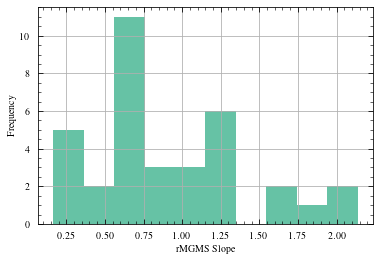

In [3]:
print(np.median(lts_slopes))
print(np.mean(lts_slopes))
print(np.std(lts_slopes))

fig, ax = plt.subplots()
ax.hist(lts_slopes)
ax.set_xlabel("rMGMS Slope")
ax.set_ylabel("Frequency")
plt.show()

sig_int:     0.0000     -0.5556
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.5556
################# Values and formal errors ################
 intercept:  8.771 +/- 0.027
     slope:  1.218 +/- 0.042
   scatter:  0. +/- 0.0
Observed rms scatter: 0.065
y = a + b*(x - pivot) with pivot = 9.826
Spearman r=0.89 and p=1.6e-12
Pearson r=0.89 and p=8.4e-13
##########################################################
seconds 1.32
NGVS-VERTICO LTS line: y = (1.2180934007441813 +/- 0.04224567415178096) * x + (-3.1979908540126907 +/- 0.41601959799117416)


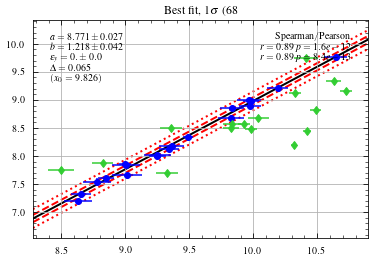

In [3]:
# 
# CORRECT VERSION using total M_star and M_mol
# 
sample_pivot = np.median(log_tot_M)
sample_lts_clip = 2.6
# 
sample_lts_popt = lts_linefit(
    np.array(log_tot_M),
    np.array(log_tot_gas),
    np.array(log_tot_M_err),
    np.array(log_tot_gas_err),
    clip=sample_lts_clip,
    epsy=True,
    corr=True,
    frac=None,
    pivot=sample_pivot,
    plot=True,
    text=True,
)

sample_lts_int, sample_lts_slope = sample_lts_popt.ab
sample_lts_int_err, sample_lts_slope_err = sample_lts_popt.ab_err
sample_lts_rms = sample_lts_popt.rms
sample_lts_yint = sample_lts_int - sample_lts_slope * sample_pivot
sample_lts_yint_err = np.sqrt(sample_lts_int_err ** 2 + (sample_lts_slope_err * sample_pivot) ** 2)

print(f"NGVS-VERTICO LTS line: y = ({sample_lts_slope} +/- {sample_lts_slope_err}) * x + ({sample_lts_yint} +/- {sample_lts_yint_err})")

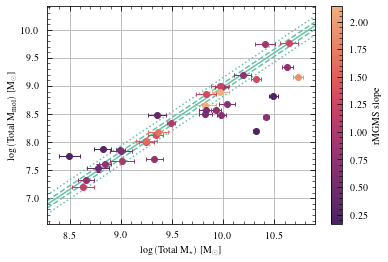

In [4]:
fig, ax = plt.subplots()
img = ax.scatter(log_tot_M, log_tot_gas, c=lts_slopes, cmap=sns.color_palette("flare_r", as_cmap=True), zorder=10, s=0)
cbar = fig.colorbar(img)
cbar.set_label("rMGMS slope")
ecolor_norm = mpl.colors.Normalize(vmin=min(lts_slopes), vmax=max(lts_slopes))
ecolor_mapper = mpl.cm.ScalarMappable(norm=ecolor_norm, cmap=sns.color_palette("flare_r", as_cmap=True))
ecolors = np.array([(ecolor_mapper.to_rgba(slope)) for slope in lts_slopes])
for x, y, xerr, yerr, ecolor in zip(log_tot_M, log_tot_gas, log_tot_M_err, log_tot_gas_err, ecolors):
    ax.errorbar(
        x=x,
        y=y,
        xerr=xerr,
        yerr=yerr,
        fmt="o",
        color=ecolor,
        ecolor=ecolor,
        elinewidth=1,
        capsize=2,
        zorder=8,
    )
ax_xlim = ax.get_xlim()
pu.add_lts_line(
    ax,
    sample_lts_slope,
    sample_lts_int,
    sample_pivot,
    lts_rms=sample_lts_rms,
    lts_clip=sample_lts_clip,
    lts_xlim=ax_xlim,
    xdata=log_tot_M,
    lts_color="C0",
)
ax.set_xlim(ax_xlim)
# pu.set_aspect(ax, 0.75)
ax.set_xlabel(r"$\rm \log\left(Total\ M_\star\right)$ [$\rm M_\odot$]")
ax.set_ylabel(r"$\rm \log\left(Total\ M_{mol}\right)$ [$\rm M_\odot$]")
# fig.savefig("NGVS-VERTICO_MGMS_total_masses_no4302_noNorm_i_corr.pdf")
plt.show()